Test

In [39]:
import pandas as pd
from pyspark.sql import SparkSession
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("model").getOrCreate()
df = spark.read.parquet("../data/gold/games/season=2023/").toPandas()
df['game_date'] = pd.to_datetime(df['game_date'])
df = df.sort_values('game_date')

print(f"Dataset: {df.shape} | Columns: {list(df.columns)}\n")

# 1. Features (only *_avg + context)
feat_cols = [c for c in df.columns if '_avg' in c.lower()]
print(f"Features: {len(feat_cols)} → {feat_cols[:5]}...")

X = df[feat_cols].fillna(0)  # avg = 0 for EPA
y_win = df['home_win']       # ← Classification 0/1
y_spread = df['final_home_margin'] # ← Regression -10/+7 ---> TO DO

Dataset: (285, 53) | Columns: ['game_id', 'game_date', 'week', 'home_team', 'away_team', 'div_game', 'is_playoffs', 'final_home_score', 'final_away_score', 'final_total_score', 'final_home_margin', 'home_win', 'total_pass_plays', 'total_rush_plays', 'total_offensive_yards', 'avg_epa_per_play', 'home_off_epa_last_4_games_avg', 'home_off_epa_season_avg', 'home_team_plays_last_4_games_avg', 'home_team_plays_season_avg', 'home_points_scored_last_4_games_avg', 'home_points_scored_season_avg', 'home_pass_yds_last_4_games_avg', 'home_pass_yds_season_avg', 'home_rush_yds_last_4_games_avg', 'home_rush_yds_season_avg', 'home_def_epa_last_4_games_avg', 'home_def_epa_season_avg', 'home_def_allowed_last_4_games_avg', 'home_def_allowed_season_avg', 'home_def_allowed_pass_yds_last_4_games_avg', 'home_def_allowed_pass_yds_season_avg', 'home_def_allowed_rush_yds_last_4_games_avg', 'home_def_allowed_rush_yds_season_avg', 'away_off_epa_last_4_games_avg', 'away_off_epa_season_avg', 'away_team_plays_last_4

Split: trained until 2023-12-24
Train: (227, 36) | Test: (58, 36)
🏆 HOME WIN ACCURACY: 0.534 (baseline 0.50)
📊 SPREAD MAE: 13.4 points


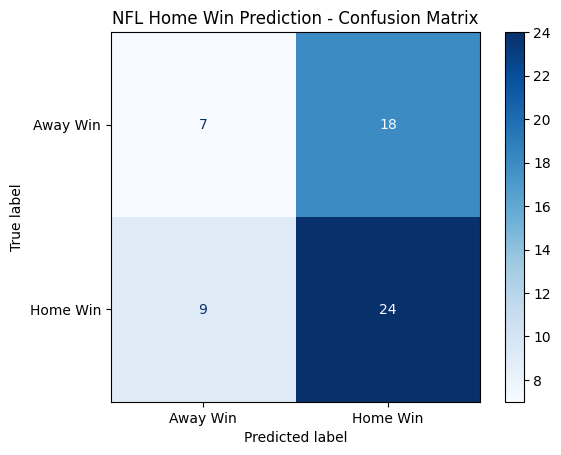

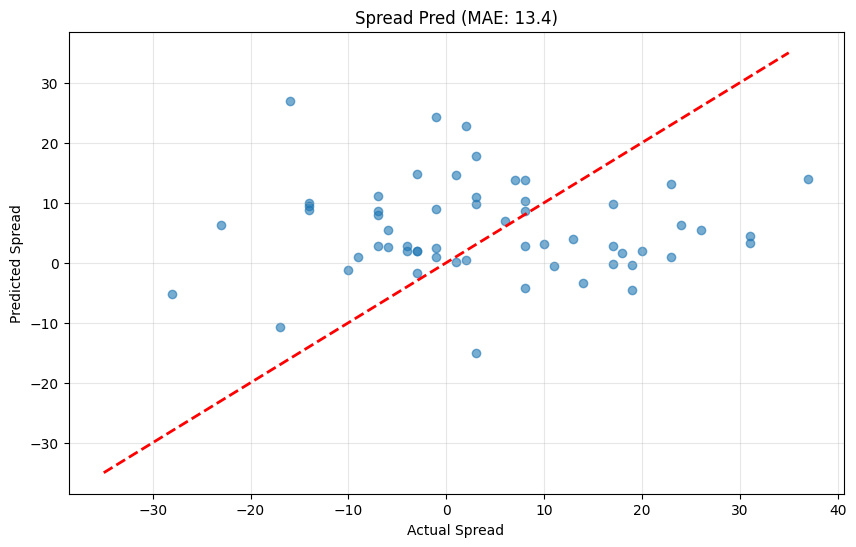

In [40]:
# 2. SPLIT
split_date = df['game_date'].quantile(0.8)
print(f"Split: trained until {split_date.date()}")

mask_train = df['game_date'] < split_date
X_train, X_test = X[mask_train], X[~mask_train]
y_train_win, y_test_win = y_win[mask_train], y_win[~mask_train]

print(f"Train: {X_train.shape} | Test: {X_test.shape}")

# 3. MODELS
# Clasification: Home team wins?
model_win = xgb.XGBClassifier(eval_metric='logloss')
model_win.fit(X_train, y_train_win)
preds_win = model_win.predict(X_test)

acc = accuracy_score(y_test_win, preds_win)
print(f"🏆 HOME WIN ACCURACY: {acc:.3f} (baseline 0.50)")

# Regresión: Spread points
model_spread = xgb.XGBRegressor(random_state=42)
model_spread.fit(X_train, y_spread[mask_train])
preds_spread = model_spread.predict(X_test)
mae = mean_absolute_error(y_spread[~mask_train], preds_spread)
print(f"📊 SPREAD MAE: {mae:.1f} points")


cm = confusion_matrix(y_test_win, preds_win)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Away Win', 'Home Win'])
disp.plot(cmap='Blues')
plt.title('NFL Home Win Prediction - Confusion Matrix')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(y_spread[~mask_train], preds_spread, alpha=0.6)  # ✅ y_test_margin
plt.plot([-35,35], [-35,35], 'r--', lw=2)
plt.xlabel('Actual Spread')
plt.ylabel('Predicted Spread')
plt.title(f'Spread Pred (MAE: {mae:.1f})')
plt.grid(True, alpha=0.3)
plt.show()

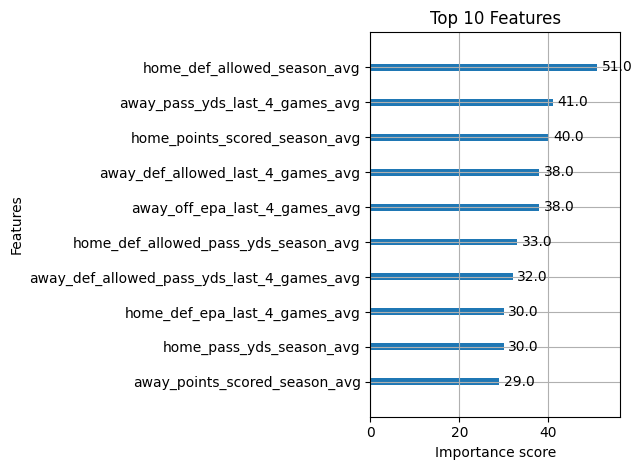

In [41]:
# 4. IMPORTANCE (WIN model)
xgb.plot_importance(model_win, max_num_features=10, title="Top 10 Features")
plt.tight_layout()
plt.show()